# Preprocessing

In [15]:
import librosa
import numpy as np

def preprocess_audio(audio_path, sample_rate=16000):
    """
    Vorverarbeitung einer Audiodatei: Resampling und Normalisierung.

    Args:
        audio_path (str): Pfad zur Audiodatei.
        sample_rate (int): Ziel-Sampling-Rate (Standard: 16000).

    Returns:
        np.array: Das vorverarbeitete Audio-Signal.
    """
    # Audiodatei laden und resamplen
    audio_signal, _ = librosa.load(audio_path, sr=sample_rate)

    # Zu Mono konvertieren (falls mehrkanalig)
    audio_signal = librosa.to_mono(audio_signal)

    # Normalisieren
    max_val = np.max(np.abs(audio_signal))
    if max_val > 0:
        audio_signal = audio_signal / max_val

    return audio_signal

# Funktion MFCC

In [18]:
import numpy as np
import librosa
from scipy.stats import skew, kurtosis

def calculate_mfcc(audio_signal, sample_rate=16000, frame_length=2048, hop_length=512, num_mfcc=13):
    """
    Berechnet erweiterte MFCCs mit Schutz gegen Precision Loss in Skewness & Kurtosis.

    Quelle:
        Davis, S., & Mermelstein, P. (1980). Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences.
        IEEE Transactions on Acoustics, Speech, and Signal Processing.

    Args:
        audio_signal (np.array): Das normalisierte Audio-Signal (1D-Array).
        sample_rate (int): Sampling-Rate des Signals (Standard: 16000 Hz).
        frame_length (int): Länge eines Frames in Samples (Standard: 2048).
        hop_length (int): Schrittweite zwischen Frames in Samples (Standard: 512).
        num_mfcc (int): Anzahl der MFCC-Koeffizienten (Standard: 13).

    Returns:
        np.array: Feature-Vektor mit MFCC-Statistiken (Dimension: 6 * num_mfcc).
    """
    mfcc_features = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)

    # Berechnung von Statistikwerten für jedes MFCC
    mfcc_mean = np.mean(mfcc_features, axis=1)     # Mittelwert
    mfcc_std = np.std(mfcc_features, axis=1)       # Standardabweichung
    mfcc_min = np.min(mfcc_features, axis=1)       # Minimum
    mfcc_max = np.max(mfcc_features, axis=1)       # Maximum
    mfcc_range = mfcc_max - mfcc_min               # Spannweite

    # **Sicherheitsprüfung für Skewness & Kurtosis**
    if np.all(np.isclose(mfcc_features, mfcc_features[:, 0][:, np.newaxis], atol=1e-8)):  
        # Falls alle Werte sehr ähnlich sind, setzen wir Skewness & Kurtosis auf 0
        mfcc_skewness = np.zeros(num_mfcc)
        mfcc_kurtosis = np.zeros(num_mfcc)
    else:
        mfcc_skewness = skew(mfcc_features, axis=1)
        mfcc_kurtosis = kurtosis(mfcc_features, axis=1)

    # Feature-Vektor: Kombination aller Werte
    return np.concatenate([mfcc_mean, mfcc_std, mfcc_min, mfcc_max, mfcc_range, mfcc_skewness, mfcc_kurtosis])

# Test

In [19]:
import os
import numpy as np

# Liste der Dateien im Audio-Ordner
audio_folder = "../audio_files"
audio_files = sorted([f for f in os.listdir(audio_folder) if f.endswith(".wav")])

# Dictionary zur Speicherung der MFCC-Werte für verschiedene Dateien
mfcc_results = {}

# Berechnung und Ausgabe der MFCC-Werte für jede Datei
for file_name in audio_files:
    file_path = os.path.join(audio_folder, file_name)

    # Audiodatei vorverarbeiten
    audio_signal = preprocess_audio(file_path)

    # Erweiterte MFCCs berechnen (Mean, Std, Min, Max, Range, Skewness, Kurtosis)
    mfcc_values = calculate_mfcc(audio_signal)

    # Speichern der Werte im Dictionary
    mfcc_results[file_name] = mfcc_values

    # Ausgabe der Werte
    print(f"MFCCs ({file_name}): {mfcc_values}")

MFCCs (_noise_pink.wav): [ 1.58031937e+02  1.16272568e+02 -7.86771631e+00  1.40624580e+01
 -2.62609243e+00  1.07773829e+00 -2.42071080e+00  1.43324211e-02
  3.10897231e-01  1.22489691e+00  1.31118655e+00  9.61811006e-01
  3.90451476e-02  8.05763149e+00  1.92982996e+00  2.48215675e+00
  2.74890661e+00  2.38529253e+00  3.10107255e+00  2.43214035e+00
  2.02149558e+00  2.30927515e+00  2.34579802e+00  2.67513728e+00
  1.64069247e+00  2.34187341e+00  1.24543152e+02  1.13706589e+02
 -1.18222065e+01  8.98211765e+00 -7.32254219e+00 -4.75448990e+00
 -6.85813808e+00 -3.54644012e+00 -5.10652065e+00 -4.26563263e+00
 -5.72011375e+00 -2.12340569e+00 -4.52184439e+00  1.65957016e+02
  1.20577042e+02 -2.95024824e+00  1.88445320e+01  3.18787575e+00
  9.59924126e+00  2.24823785e+00  3.60626364e+00  5.25051594e+00
  5.14485979e+00  5.81157684e+00  5.31251431e+00  5.70145607e+00
  4.14138641e+01  6.87045288e+00  8.87195778e+00  9.86241436e+00
  1.05104179e+01  1.43537312e+01  9.10637569e+00  7.15270376e+00


# --- Auswertung ---

In [4]:
import numpy as np
import librosa

def calculate_mfcc(audio_signal, sample_rate=16000, frame_length=2048, hop_length=512, num_mfcc=13):
    """
    Berechnet die Mel-Frequency Cepstral Coefficients (MFCCs) eines Audiosignals.

    Quelle:
        Davis, S., & Mermelstein, P. (1980). Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences.
        IEEE Transactions on Acoustics, Speech, and Signal Processing.

    Args:
        audio_signal (np.array): Das normalisierte Audio-Signal (1D-Array).
        sample_rate (int): Sampling-Rate des Signals (Standard: 16000 Hz).
        frame_length (int): Länge eines Frames in Samples (Standard: 2048).
        hop_length (int): Schrittweite zwischen Frames in Samples (Standard: 512).
        num_mfcc (int): Anzahl der MFCC-Koeffizienten (Standard: 13).

    Returns:
        np.array: MFCC-Werte für jedes Frame.
    """
    mfcc_features = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)
    return mfcc_features  # Gibt die MFCC-Matrix zurück (nicht den Mittelwert)

In [6]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_mfcc(mfcc_features, sample_rate=16000, hop_length=512, file_name="unknown"):
    """
    Visualisiert MFCCs als Heatmap.

    Args:
        mfcc_features (np.array): MFCC-Matrix.
        sample_rate (int): Sampling-Rate (Standard: 16000 Hz).
        hop_length (int): Schrittweite zwischen Frames in Samples (Standard: 512).
        file_name (str): Name der Datei zur Anzeige in der Grafik.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc_features, x_axis='time', sr=sample_rate, hop_length=hop_length, cmap='coolwarm')
    plt.colorbar(label="MFCC Amplitude")
    plt.title(f"MFCC Heatmap: {file_name}")
    plt.xlabel("Zeit (Frames)")
    plt.ylabel("MFCC-Koeffizienten")
    plt.show()

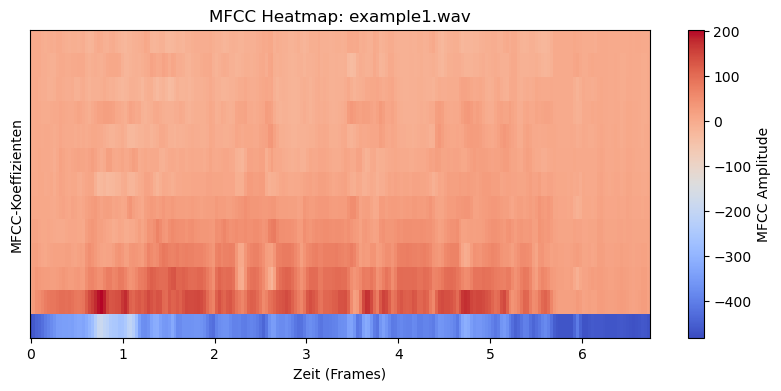

In [7]:
import os

# MFCCs für eine Datei berechnen und visualisieren
test_file = "../audio_files/example1.wav"  # Wählen Sie eine Datei zur Analyse
audio_signal = preprocess_audio(test_file)

# Berechnung der MFCCs
mfcc_values = calculate_mfcc(audio_signal)

# Visualisierung der MFCC-Heatmap
visualize_mfcc(mfcc_values, file_name="example1.wav")

# MEL

In [8]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def calculate_mel_spectrogram(audio_signal, sample_rate=16000, frame_length=2048, hop_length=512, n_mels=128):
    """
    Berechnet das Mel-Spektrogramm eines Audiosignals.

    Quelle:
        Logan, B. (2000). Mel frequency cepstral coefficients for music modeling.
        Proceedings of ISMIR.

    Args:
        audio_signal (np.array): Das normalisierte Audio-Signal (1D-Array).
        sample_rate (int): Sampling-Rate des Signals (Standard: 16000 Hz).
        frame_length (int): Länge eines Frames in Samples (Standard: 2048).
        hop_length (int): Schrittweite zwischen Frames in Samples (Standard: 512).
        n_mels (int): Anzahl der Mel-Bänder (Standard: 128).

    Returns:
        np.array: Mel-Spektrogramm.
    """
    mel_spec = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
    
    # Umwandlung in dB-Skala für bessere Visualisierung
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

In [9]:
def visualize_mel_spectrogram(mel_spec_db, sample_rate=16000, hop_length=512, file_name="unknown"):
    """
    Visualisiert das Mel-Spektrogramm als Heatmap.

    Args:
        mel_spec_db (np.array): Mel-Spektrogramm in dB-Skala.
        sample_rate (int): Sampling-Rate (Standard: 16000 Hz).
        hop_length (int): Schrittweite zwischen Frames in Samples (Standard: 512).
        file_name (str): Name der Datei zur Anzeige in der Grafik.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length, cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel-Spectrogram: {file_name}")
    plt.xlabel("Zeit (Frames)")
    plt.ylabel("Mel-Frequenzbänder")
    plt.show()

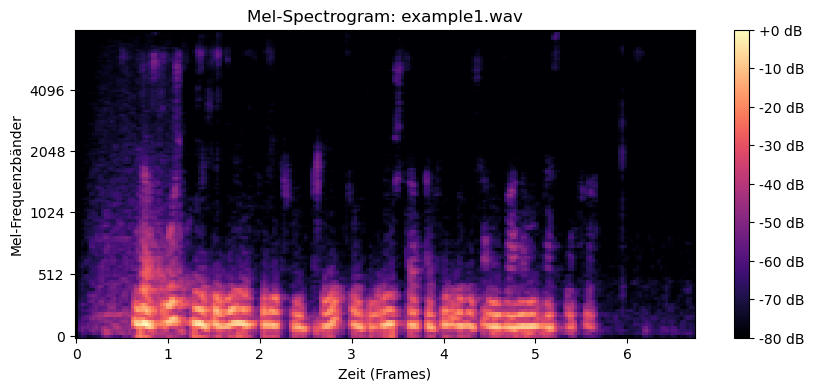